In [1]:
import sys
print(sys.executable)

/opt/anaconda3/envs/portfolio_opt/bin/python


# Portfolio Optimization Tool

This project builds a quantitative portfolio optimization model using real market data.
It compares an optimized portfolio with an equal weight portfolio using risk and return metrics.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf

from scipy.optimize import minimize

In [3]:
tickers = ["AAPL", "MSFT", "GOOGL", "AMZN"] 

In [4]:
data = yf.download(
    tickers,
    start="2019-01-01",
    end="2024-01-01",
    auto_adjust=True
)

data.head()

[*********************100%***********************]  4 of 4 completed


Price           Close                                        High             \
Ticker           AAPL       AMZN      GOOGL       MSFT       AAPL       AMZN   
Date                                                                           
2019-01-02  37.538822  76.956497  52.338543  94.612625  37.759892  77.667999   
2019-01-03  33.799679  75.014000  50.888992  91.132011  34.638787  76.900002   
2019-01-04  35.242561  78.769501  53.499271  95.370483  35.311499  79.699997   
2019-01-07  35.164120  81.475502  53.392582  95.492104  35.378059  81.727997   
2019-01-08  35.834450  82.829002  53.861546  96.184502  36.088799  83.830498   

Price                                   Low                                   \
Ticker          GOOGL       MSFT       AAPL       AMZN      GOOGL       MSFT   
Date                                                                           
2019-01-02  52.641752  95.202080  36.661680  73.046501  50.879565  92.572914   
2019-01-03  52.913199  93.742467  33.754514  74.855499  50.735156  90.944878   
2019-01-04  53.595048  95.913160  34.182386  75.915497  51.454222  92.563543   
2019-01-07  53.729037  96.624235  34.681573  79.459503  52.733560  94.481611   
2019-01-08  54.257552  97.279207  35.304362  80.830498  53.016925  95.164643   

Price            Open                                      Volume             \
Ticker           AAPL       AMZN      GOOGL       MSFT       AAPL       AMZN   
Date                                                                           
2019-01-02  36.818568  73.260002  50.974846  93.143660  148158800  159662000   
2019-01-03  34.225174  76.000504  52.139546  93.658255  365248800  139512000   
2019-01-04  34.355912  76.500000  51.737085  93.302705  234428400  183652000   
2019-01-07  35.347156  80.115501  53.643187  95.099134  219111200  159864000   
2019-01-08  35.551577  83.234497  53.892807  96.409055  164101200  177628000   

Price                           
Ticker         GOOGL      MSFT  
Date                            
2019-01-02  31868000  35329300  
2019-01-03  41960000  42579100  
2019-01-04  46022000  44060600  
2019-01-07  47446000  35656100  
2019-01-08  35414000  31514400

In [5]:
close_prices = data['Close']
close_prices.head() 

Ticker,AAPL,AMZN,GOOGL,MSFT
Date,,,,
2019-01-02,37.538822,76.956497,52.338543,94.612625
2019-01-03,33.799679,75.014000,50.888992,91.132011
2019-01-04,35.242561,78.769501,53.499271,95.370483
2019-01-07,35.164120,81.475502,53.392582,95.492104
2019-01-08,35.834450,82.829002,53.861546,96.184502


In [6]:
returns = close_prices.pct_change().dropna()
returns.head() 

Ticker,AAPL,AMZN,GOOGL,MSFT
Date,,,,
2019-01-03,-0.099607,-0.025241,-0.027696,-0.036788
2019-01-04,0.042689,0.050064,0.051294,0.046509
2019-01-07,-0.002226,0.034353,-0.001994,0.001275
2019-01-08,0.019063,0.016612,0.008783,0.007251
2019-01-09,0.016982,0.001714,-0.003428,0.014300


In [7]:
mean_returns = returns.mean() * 252
cov_matrix = returns.cov() * 252

In [8]:
def portfolio_performance(weights, mean_returns, cov_matrix):
    portfolio_return = np.dot(weights, mean_returns)
    portfolio_volatility = np.sqrt(
        np.dot(weights.T, np.dot(cov_matrix, weights))
    )
    return portfolio_return, portfolio_volatility

In [9]:
def minimize_volatility(weights, mean_returns, cov_matrix):
    return portfolio_performance(weights, mean_returns, cov_matrix)[1] 

In [10]:
constraints = ({
    'type': 'eq',
    'fun': lambda x: np.sum(x) - 1
})

bounds = tuple((0, 1) for i in range(len(close_prices.columns)))

In [11]:
initial_weights = np.array(
    len(close_prices.columns) * [1 / len(close_prices.columns)]
)

In [12]:
optimized_result = minimize(
    minimize_volatility,
    initial_weights,
    args=(mean_returns, cov_matrix),
    method='SLSQP',
    bounds=bounds,
    constraints=constraints
)

optimal_weights = optimized_result.x

In [13]:
for ticker, weight in zip(close_prices.columns, optimal_weights):
    print(f"{ticker}: {weight:.2%}")

AAPL: 25.76%
AMZN: 14.45%
GOOGL: 27.70%
MSFT: 32.09%


In [14]:
equal_weights = np.array(
    len(close_prices.columns) * [1 / len(close_prices.columns)]
)

opt_return, opt_risk = portfolio_performance(
    optimal_weights, mean_returns, cov_matrix
)

eq_return, eq_risk = portfolio_performance(
    equal_weights, mean_returns, cov_matrix
)

print("Optimized Portfolio")
print(f"Expected Return: {opt_return:.2%}")
print(f"Risk (Volatility): {opt_risk:.2%}")

print("\nEqual-Weight Portfolio")
print(f"Expected Return: {eq_return:.2%}")
print(f"Risk (Volatility): {eq_risk:.2%}")


Optimized Portfolio
Expected Return: 29.70%
Risk (Volatility): 28.30%

Equal-Weight Portfolio
Expected Return: 28.57%
Risk (Volatility): 28.42%


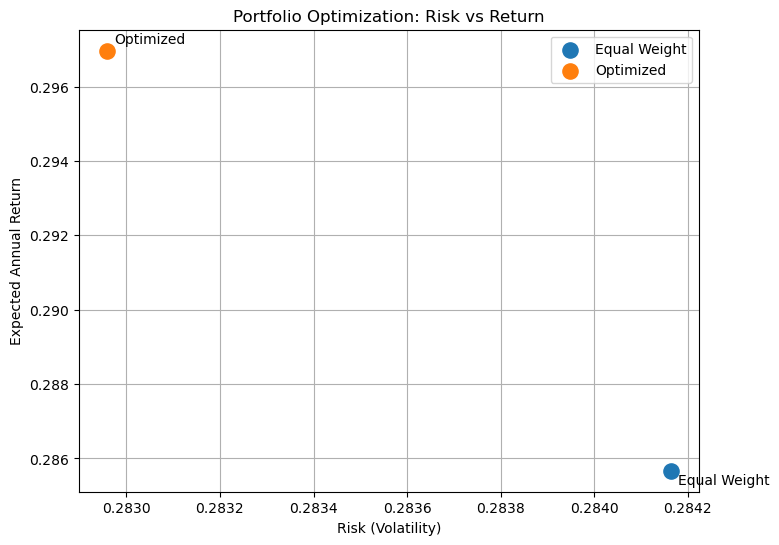

In [15]:
plt.figure(figsize=(8, 6))

plt.scatter(eq_risk, eq_return, s=120, label="Equal Weight")
plt.scatter(opt_risk, opt_return, s=120, label="Optimized")

plt.annotate("Equal Weight",
             (eq_risk, eq_return),
             textcoords="offset points",
             xytext=(5, -10))

plt.annotate("Optimized",
             (opt_risk, opt_return),
             textcoords="offset points",
             xytext=(5, 5))

plt.xlabel("Risk (Volatility)")
plt.ylabel("Expected Annual Return")
plt.title("Portfolio Optimization: Risk vs Return")
plt.legend()
plt.grid(True)

plt.show()


In this project, I showed how quantitative portfolio optimization can be used to make smarter investment decisions. Instead of allocating capital evenly, this model uses historical market data and the relationships between assets to reduce risk while still achieving strong returns.

By applying covariance analysis and constrained optimization, the optimized portfolio delivered better risk-adjusted performance than a simple equal weight approach. This highlights how data driven methods and diversification can improve portfolio outcomes.
